## import libraries

In [285]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## import Data

In [286]:
df= pd.read_csv('employee_retention_data.csv')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [287]:
df['Quit'] = df['quit_date'].isnull()

In [288]:
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_datetime(df[col])
        except ValueError:
            pass

In [289]:
a = max(df['quit_date'])

In [290]:
df['quit_date']= df['quit_date'].fillna(a)

In [291]:
df['duration'] = df['quit_date']- df['join_date']

In [292]:
df['duration'] = df['duration'].apply(lambda x: x.days)

In [293]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Quit,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-09,True,422
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040


## EDA

C:\Users\pouya\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\pouya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\pouya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\pouya\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


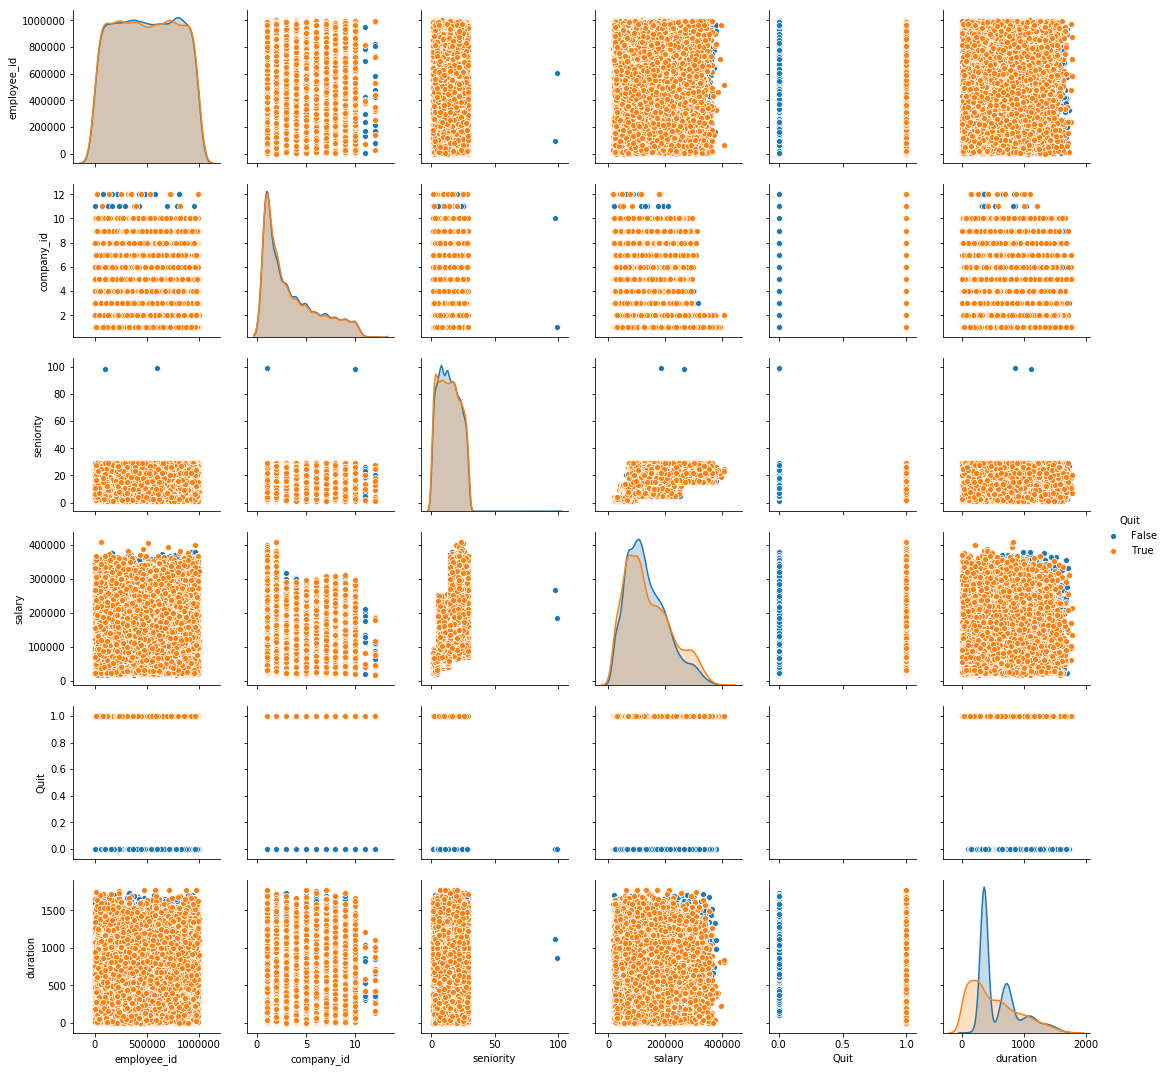

In [294]:
sns.pairplot(data= df, hue='Quit')

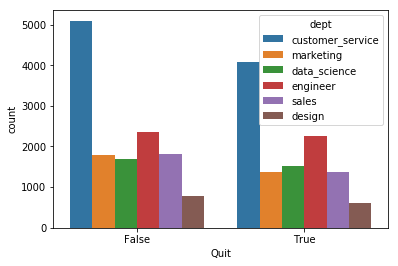

In [303]:
df['Quit'] = df['Quit'].astype(str)
sns.countplot(x='Quit', hue='dept', data=df)

In [199]:
company_id  = pd.get_dummies(df['company_id'])

In [200]:
df = pd.concat([df, company_id], axis=1)

In [201]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Quit,duration,1,...,3,4,5,6,7,8,9,10,11,12
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585,0,...,0,0,0,0,1,0,0,0,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340,0,...,0,0,0,0,1,0,0,0,0,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-09,True,422,0,...,0,1,0,0,0,0,0,0,0,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389,0,...,0,0,0,0,1,0,0,0,0,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040,0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
X = df.drop(['employee_id', 'company_id'], axis=1)

In [203]:
X['dept'].nunique(), X['seniority'].nunique()

(6, 31)

In [204]:
X['Quit'].value_counts()

False    13510
True     11192
Name: Quit, dtype: int64

In [205]:
X.head()

,dept,seniority,salary,join_date,quit_date,Quit,duration,1,2,3,4,5,6,7,8,9,10,11,12
0,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585,0,0,0,0,0,0,1,0,0,0,0,0
1,marketing,20,183000.0,2013-04-29,2014-04-04,False,340,0,0,0,0,0,0,1,0,0,0,0,0
2,marketing,14,101000.0,2014-10-13,2015-12-09,True,422,0,0,0,1,0,0,0,0,0,0,0,0
3,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389,0,0,0,0,0,0,1,0,0,0,0,0
4,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040,0,1,0,0,0,0,0,0,0,0,0,0


In [206]:
X = X.drop(['join_date', 'quit_date', 'Quit'], axis=1)
y = df['Quit']

In [207]:
Dept = pd.get_dummies(X['dept'], drop_first=True)

In [208]:
X= pd.concat([X,Dept], axis=1)

In [209]:
X.drop('dept', axis=1, inplace=True)

In [210]:
X.head()

,seniority,salary,duration,1,2,3,4,5,6,7,8,9,10,11,12,data_science,design,engineer,marketing,sales
0,28,89000.0,585,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,20,183000.0,340,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,14,101000.0,422,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,20,115000.0,389,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,23,276000.0,1040,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [212]:
clf= RandomForestClassifier()
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

C:\Users\pouya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [213]:
accuracy_score(y_test, predict)

0.7081697742885181

## GRID SEARCH CV on ADABOOST

In [256]:
rnd_clf= AdaBoostClassifier()
scorer = make_scorer(accuracy_score)
parameters ={'n_estimators': (10,30,70,90), 'learning_rate': (0.1,0.001,1,10)}
clf = GridSearchCV(rnd_clf, parameters, scoring=scorer, cv=10)

In [257]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (10, 30, 70, 90), 'learning_rate': (0.1, 0.001, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [258]:
best_clf = clf.best_estimator_
best_predictions = best_clf.predict(X_test)
Test_accuracy = accuracy_score(y_test, best_predictions)
best_predictions_train = best_clf.predict(X_train)
Training_accuracy = accuracy_score(y_train, best_predictions_train)

In [260]:
Test_accuracy

0.7539254170755643

## important Features

In [274]:
best_clf.feature_importances_

array([0.01428571, 0.08571429, 0.88571429, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01428571,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [281]:
X.columns[[0,1,2,9]]

Index(['seniority', 'salary', 'duration', 7], dtype='object')